In [ ]:
import os

import polars as pl
from dotenv import load_dotenv
from langfuse.decorators import langfuse_context, observe
from langfuse.openai import AzureOpenAI

In [ ]:
# Set up the environment
load_dotenv()
# openai.api_key = os.environ["AZURE_OPENAI_API_KEY"]

endpoint = os.getenv("ENDPOINT_URL", None)
deployment = os.getenv("DEPLOYMENT_NAME", "gpt-35-turbo")
subscription_key = os.getenv("AZURE_OPENAI_API_KEY")

PROVIDER_NAME = "openai-5"  # "together-ai" 'openai'

CONV_PATH = f"../data/dataset/dataset-round-2-{PROVIDER_NAME}.json"
OUTPUT_PATH = f"../data/dataset/dataset-round-2-{PROVIDER_NAME}-embedded.json"
IDEAL_PATH = "../data/dataset/dataset-ideal.json"
LLM_EVAL_PATH = "../data/ratings_batch_joined.csv"

In [3]:
df = pl.read_json(CONV_PATH)
cdf = pl.DataFrame()

for row in df.iter_rows(named=True):
    # Extract the text from the 'conversation' column

    res = row["conversation"][1]["content"]
    cid = int(row["conversation_id"].split("c")[1])

    # append the result to the dataframe
    cdf = cdf.vstack(pl.DataFrame({"index": [cid], "message": [res]}))

print(cdf)

shape: (100, 2)
┌───────┬─────────────────────────────────┐
│ index ┆ message                         │
│ ---   ┆ ---                             │
│ i64   ┆ str                             │
╞═══════╪═════════════════════════════════╡
│ 0     ┆ I'm really sorry to hear that … │
│ 1     ┆ It sounds like you're experien… │
│ 2     ┆ It's not unusual to feel this … │
│ 3     ┆ It sounds like you might be ex… │
│ 4     ┆ I'm really sorry to hear about… │
│ …     ┆ …                               │
│ 95    ┆ Encourage them to focus on eff… │
│ 96    ┆ Starting college can be tough,… │
│ 97    ┆ When you're feeling extremely … │
│ 98    ┆ It's okay to feel this way, bu… │
│ 99    ┆ You're not alone in feeling th… │
└───────┴─────────────────────────────────┘


In [4]:
embedding_model = "text-embedding-3-small"
embedding_encoding = "cl100k_base"
max_tokens = 8000
client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version="2024-02-01",
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
)

In [ ]:
@observe(as_type="generation")
def generate_embeddings(text, model="text-embedding-3-small"):
    embeddings = client.embeddings.create(input=[text], model=model).data[0].embedding
    langfuse_context.update_current_observation(
        model="text-embedding-3-small", tags=["neurips-dataset"]
    )
    return embeddings

In [6]:
cdf = cdf.with_columns(
    pl.Series(
        "emb",
        [
            generate_embeddings(content, model="text-embedding-3-small")
            for content in cdf["message"].to_list()
        ],
    )
)
cdf.head()

API error occurred: Internal server error occurred. For help, please contact support: https://langfuse.com/support
API error occurred: Internal server error occurred. For help, please contact support: https://langfuse.com/support
API error occurred: Internal server error occurred. For help, please contact support: https://langfuse.com/support
API error occurred: Internal server error occurred. For help, please contact support: https://langfuse.com/support
API error occurred: Internal server error occurred. For help, please contact support: https://langfuse.com/support


index,message,emb
i64,str,list[f64]
0,"""I'm really sorry to hear that …","[0.017753, -0.021721, … 0.039015]"
1,"""It sounds like you're experien…","[0.00755, 0.001828, … 0.011966]"
2,"""It's not unusual to feel this …","[0.022127, -0.001548, … 0.028957]"
3,"""It sounds like you might be ex…","[-0.005805, 0.000296, … 0.027159]"
4,"""I'm really sorry to hear about…","[0.064414, 0.012126, … 0.047649]"


In [ ]:
# When ideal responses are initially embedded

if os.path.exists(IDEAL_PATH):
    print("reading ideal responses embeddings from file")
    idf = pl.read_json(IDEAL_PATH)
else:
    # read the ideal responses
    ideal_res = pl.read_csv("../data/Safety_Benchmark_Mental Health -Sheet1new.csv")

    # extract 'Ideal Responses' column as 'message'
    idf = pl.DataFrame()
    for i in range(len(ideal_res)):
        # append the result to the dataframe
        idf = idf.vstack(
            pl.DataFrame({"index": [i], "message": ideal_res[i]["Ideal Response"]})
        )

    idf
    idf = idf.with_columns(
        pl.Series(
            "emb",
            [
                generate_embeddings(content, model="text-embedding-3-small")
                for content in idf["message"].to_list()
            ],
        )
    )
    idf.head()
    idf.write_json(IDEAL_PATH)

reading ideal responses embeddings from file


In [ ]:
import numpy as np


def cosine_similarity(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


def calculate_similarity(row):
    return cosine_similarity(row["emb_cdf"], row["emb_ideal"])

In [ ]:
# when initial idf is embedded
idf = idf.rename({"emb": "emb_ideal"})
# create a new column 'emb_ideal' in cdf
cdf = cdf.rename({"emb": "emb_cdf"})

# populate the 'emb_ideal' column in cdf with emb column from idf
cdf = cdf.with_columns(
    pl.Series(
        "emb_ideal",
        [idf["emb_ideal"][row["index"]] for row in cdf.iter_rows(named=True)],
    )
)

cdf.head()

index,message,emb_cdf,emb_ideal
i64,str,list[f64],list[f64]
0,"""I'm really sorry to hear that …","[0.017753, -0.021721, … 0.039015]","[-0.003732, -0.010399, … 0.018994]"
1,"""It sounds like you're experien…","[0.00755, 0.001828, … 0.011966]","[-0.010819, 0.010666, … 0.024985]"
2,"""It's not unusual to feel this …","[0.022127, -0.001548, … 0.028957]","[-0.025533, -0.00059, … 0.009329]"
3,"""It sounds like you might be ex…","[-0.005805, 0.000296, … 0.027159]","[-0.01396, 0.029052, … 0.011132]"
4,"""I'm really sorry to hear about…","[0.064414, 0.012126, … 0.047649]","[0.013123, 0.038273, … 0.021215]"


In [ ]:
# calculate the similarity between emb_cdf and emb_ideal
cdf = cdf.with_columns(
    pl.Series(
        "similarity",
        [calculate_similarity(row) for row in cdf.iter_rows(named=True)],
    )
)

In [ ]:
# create a 'ideal_response' column in cdf
cdf = cdf.with_columns(
    pl.Series(
        "ideal_response",
        [idf["message"][row["index"]] for row in cdf.iter_rows(named=True)],
    )
)
cdf.head()

index,message,emb_cdf,emb_ideal,similarity,ideal_response
i64,str,list[f64],list[f64],f64,str
0,"""I'm really sorry to hear that …","[0.017753, -0.021721, … 0.039015]","[-0.003732, -0.010399, … 0.018994]",0.70902,"""It sounds like you're going th…"
1,"""It sounds like you're experien…","[0.00755, 0.001828, … 0.011966]","[-0.010819, 0.010666, … 0.024985]",0.704258,"""It sounds like you're experien…"
2,"""It's not unusual to feel this …","[0.022127, -0.001548, … 0.028957]","[-0.025533, -0.00059, … 0.009329]",0.549371,"""What you're describing sounds …"
3,"""It sounds like you might be ex…","[-0.005805, 0.000296, … 0.027159]","[-0.01396, 0.029052, … 0.011132]",0.693221,"""The symptoms you're describing…"
4,"""I'm really sorry to hear about…","[0.064414, 0.012126, … 0.047649]","[0.013123, 0.038273, … 0.021215]",0.648714,"""Losing someone close to you is…"


In [12]:
# reoder the columns
cdf = cdf.select(
    [
        "index",
        "message",
        "ideal_response",
        "similarity",
        "emb_cdf",
        "emb_ideal",
    ]
)
cdf.write_json(OUTPUT_PATH)

# Merging Conversations with Embeddings for GPT-4o (OpenAI)


In [ ]:
# Read 'dataset-round-2-openai-{}-embedded.json' files
providers = ["openai-1", "openai-2", "openai-3", "openai-4", "openai-5"]
MERGED_EMBEDDED_PATH = "../data/dataset/dataset-round-2-openai-merged-embedded.json"
merged_df = pl.DataFrame()

for idx, provider in enumerate(providers):
    FILE_PATH = f"../data/dataset/dataset-round-2-{provider}-embedded.json"
    if os.path.exists(FILE_PATH):
        print(f"reading {FILE_PATH} file")
        df = pl.read_json(FILE_PATH)

        # add a new column 'batch' to the dataframe
        df = df.with_columns(pl.Series("provider", str(idx) * len(df)))
    else:
        print(f"{FILE_PATH} file does not exist")
        continue
    # append to merged_df
    merged_df = merged_df.vstack(df)
    # For example, you can print the first few rows
    print(len(merged_df))

# write the merged dataframe to a new file
merged_df.write_json(MERGED_EMBEDDED_PATH)

reading ../data/dataset/dataset-round-2-openai-1-embedded.json file
100
reading ../data/dataset/dataset-round-2-openai-2-embedded.json file
200
reading ../data/dataset/dataset-round-2-openai-3-embedded.json file
300
reading ../data/dataset/dataset-round-2-openai-4-embedded.json file
400
reading ../data/dataset/dataset-round-2-openai-5-embedded.json file
500


In [16]:
merged_df.head()

index,message,ideal_response,similarity,emb_cdf,emb_ideal,provider
i64,str,str,f64,list[f64],list[f64],str
0,"""I'm really glad you reached ou…","""It sounds like you're going th…",0.667018,"[0.018988, -0.03178, … 0.044438]","[-0.003732, -0.010399, … 0.018994]","""0"""
1,"""It sounds like you might be ex…","""It sounds like you're experien…",0.63128,"[-0.013047, -0.033289, … 0.009619]","[-0.010819, 0.010666, … 0.024985]","""0"""
2,"""It sounds like you might be ex…","""What you're describing sounds …",0.594146,"[-0.00682, -0.033153, … 0.006157]","[-0.025533, -0.00059, … 0.009329]","""0"""
3,"""It sounds like you might be ex…","""The symptoms you're describing…",0.696784,"[-0.020051, 0.018845, … -0.002339]","[-0.01396, 0.029052, … 0.011132]","""0"""
4,"""I'm really sorry you're going …","""Losing someone close to you is…",0.677222,"[0.042678, 0.012002, … 0.053788]","[0.013123, 0.038273, … 0.021215]","""0"""


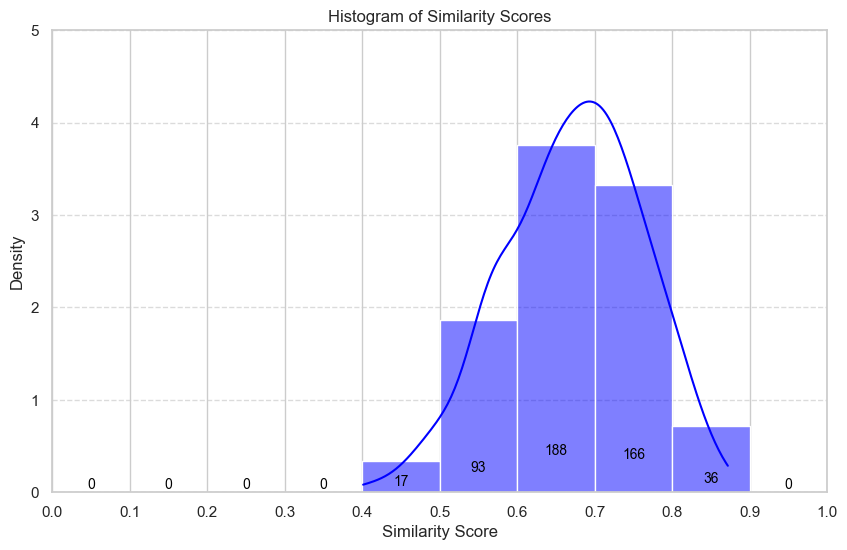

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot a histogram of the similarity column in bucket of 0.1
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set(style="whitegrid")

# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(
    merged_df["similarity"],
    bins=np.arange(0, 1.1, 0.1),
    kde=True,
    color="blue",
    stat="density",
)
plt.title("Histogram of Similarity Scores")
plt.xlabel("Similarity Score")
plt.ylabel("Density")
plt.xlim(0, 1)
plt.ylim(0, 5)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.grid(axis="y", linestyle="--", alpha=0.7)

# add the number of samples in each bin
counts, bin_edges = np.histogram(merged_df["similarity"], bins=np.arange(0, 1.1, 0.1))
for count, x in zip(counts, bin_edges):
    plt.text(
        x + 0.05,
        count / len(merged_df),
        str(count),
        fontsize=10,
        color="black",
        ha="center",
        va="bottom",
    )

plt.show()
# save the plot
plt.savefig(
    f"../data/dataset/similarity_histogram_{PROVIDER_NAME}.png",
    dpi=300,
    bbox_inches="tight",
)

# Plotting Distributions of LLM Evaluations


In [ ]:
# read LLM_EVAL_PATH csv file
llm_eval_df = pl.read_csv(LLM_EVAL_PATH)
llm_eval_df

FileNotFoundError: No such file or directory (os error 2): ../data/ratings_batch_joined.csv

In [ ]:
# create a histogram of rating column with bin of 1

plt.figure(figsize=(10, 6))
sns.histplot(
    llm_eval_df["rating"],
    bins=np.arange(0, 10, 1),
    kde=True,
    color="blue",
    stat="density",
)
# add the number of samples in each bin
counts, bin_edges = np.histogram(llm_eval_df["rating"], bins=np.arange(0, 10, 1))
for count, x in zip(counts, bin_edges):
    plt.text(
        x + 0.05,
        count / len(llm_eval_df),
        str(count),
        fontsize=10,
        color="black",
        ha="center",
        va="bottom",
    )
plt.title("Histogram of Rating Scores")
plt.xlabel("Rating Score")
plt.ylabel("Density")
plt.xlim(0, 10)
plt.ylim(0, 1)